In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
basket = pd.read_csv("Groceries_dataset.csv")
basket.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
basket.describe()

,Member_number
count,38765.000000
mean,3003.641868
std,1153.611031
min,1000.000000
25%,2002.000000
50%,3005.000000
75%,4007.000000
max,5000.000000


In [4]:
basket.itemDescription=basket.itemDescription = basket.itemDescription.transform(lambda x: [x])
basket = basket.groupby(['Member_number','Date']).sum()['itemDescription'].reset_index(drop=True)
encoder=TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(basket).transform(basket), columns=encoder.columns_)
display(transactions.head())

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
frequent_itemsets = apriori(transactions, min_support= 2/len(basket), use_colnames=True, max_len = 2)
rules = association_rules(frequent_itemsets, metric="lift",  min_threshold = 1.5)
display(rules.head())
print("Rules identified: ", len(rules))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(butter milk),(Instant food products),0.017577,0.004010,0.000134,0.007605,1.896451,0.000063,1.003622,0.481156
1,(Instant food products),(butter milk),0.004010,0.017577,0.000134,0.033333,1.896451,0.000063,1.016300,0.474602
2,(cake bar),(Instant food products),0.006148,0.004010,0.000134,0.021739,5.421377,0.000109,1.018123,0.820590
3,(Instant food products),(cake bar),0.004010,0.006148,0.000134,0.033333,5.421377,0.000109,1.028122,0.818828
4,(long life bakery product),(Instant food products),0.017911,0.004010,0.000134,0.007463,1.861070,0.000062,1.003479,0.471113


Rules identified:  1464


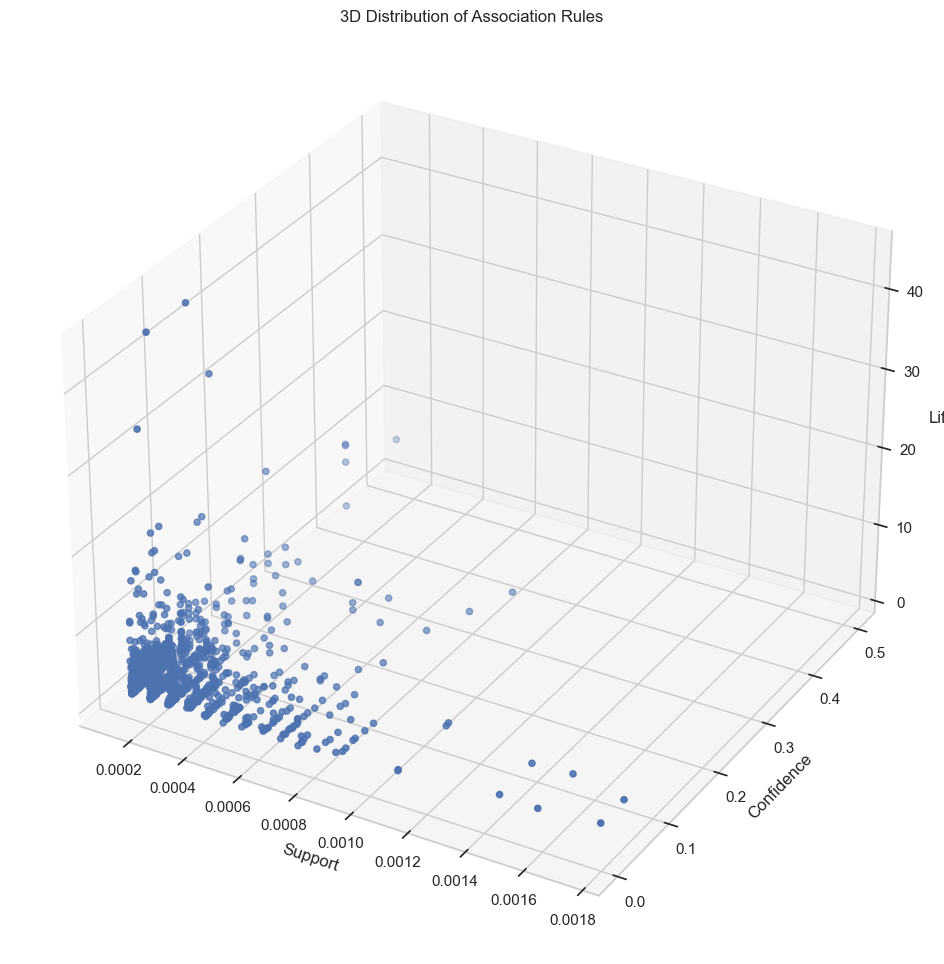

In [6]:
sns.set(style = "whitegrid")
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection = '3d')


x = rules['support']
y = rules['confidence']
z = rules['lift']

ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_zlabel("Lift")

ax.scatter(x, y, z)
ax.set_title("3D Distribution of Association Rules")

plt.show()

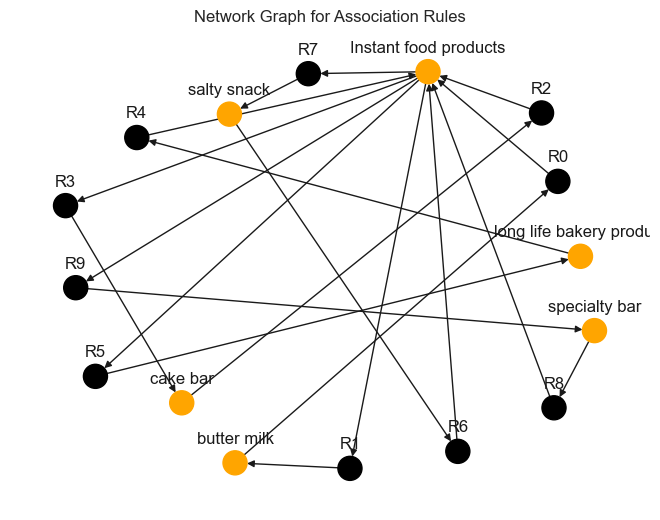

In [7]:
def draw_network(rules, rules_to_show):
  # Directional Graph from NetworkX
  network = nx.DiGraph()
  
  # Loop through number of rules to show
  for i in range(rules_to_show):
    
    # Add a Rule Node
    network.add_nodes_from(["R"+str(i)])
    for antecedents in rules.iloc[i]['antecedents']: 
        # Add antecedent node and link to rule
        network.add_nodes_from([antecedents])
        network.add_edge(antecedents, "R"+str(i),  weight = 2)
      
    for consequents in rules.iloc[i]['consequents']:
        # Add consequent node and link to rule
        network.add_nodes_from([consequents])
        network.add_edge("R"+str(i), consequents,  weight = 2)

  color_map=[]  
  
  # For every node, if it's a rule, colour as Black, otherwise Orange
  for node in network:
       if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append('black')
       else:
            color_map.append('orange')
  
  # Position nodes using spring layout
  pos = nx.spring_layout(network, k=16, scale=1)
  # Draw the network graph
  nx.draw(network, pos, node_color = color_map, font_size=8)            
  
  # Shift the text position upwards
  for p in pos:  
      pos[p][1] += 0.12

  nx.draw_networkx_labels(network, pos)
  plt.title("Network Graph for Association Rules")
  plt.show()

draw_network(rules, 10)

In [8]:
milk_rules = rules[rules['consequents'].astype(str).str.contains('whole milk')]
milk_rules = milk_rules.sort_values(by=['lift'],ascending = [False]).reset_index(drop = True)
display(milk_rules.head())

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(rubbing alcohol),(whole milk),0.000334,0.157923,0.000134,0.400000,2.532882,0.000081,1.403462,0.605395
1,(brandy),(whole milk),0.002540,0.157923,0.000869,0.342105,2.166281,0.000468,1.279957,0.539750
2,(softener),(whole milk),0.002740,0.157923,0.000802,0.292683,1.853328,0.000369,1.190523,0.461695
3,(canned fruit),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908,0.447899
4,(syrup),(whole milk),0.001403,0.157923,0.000401,0.285714,1.809201,0.000179,1.178908,0.447899


<Axes: xlabel='antecedent support', ylabel='consequent support'>

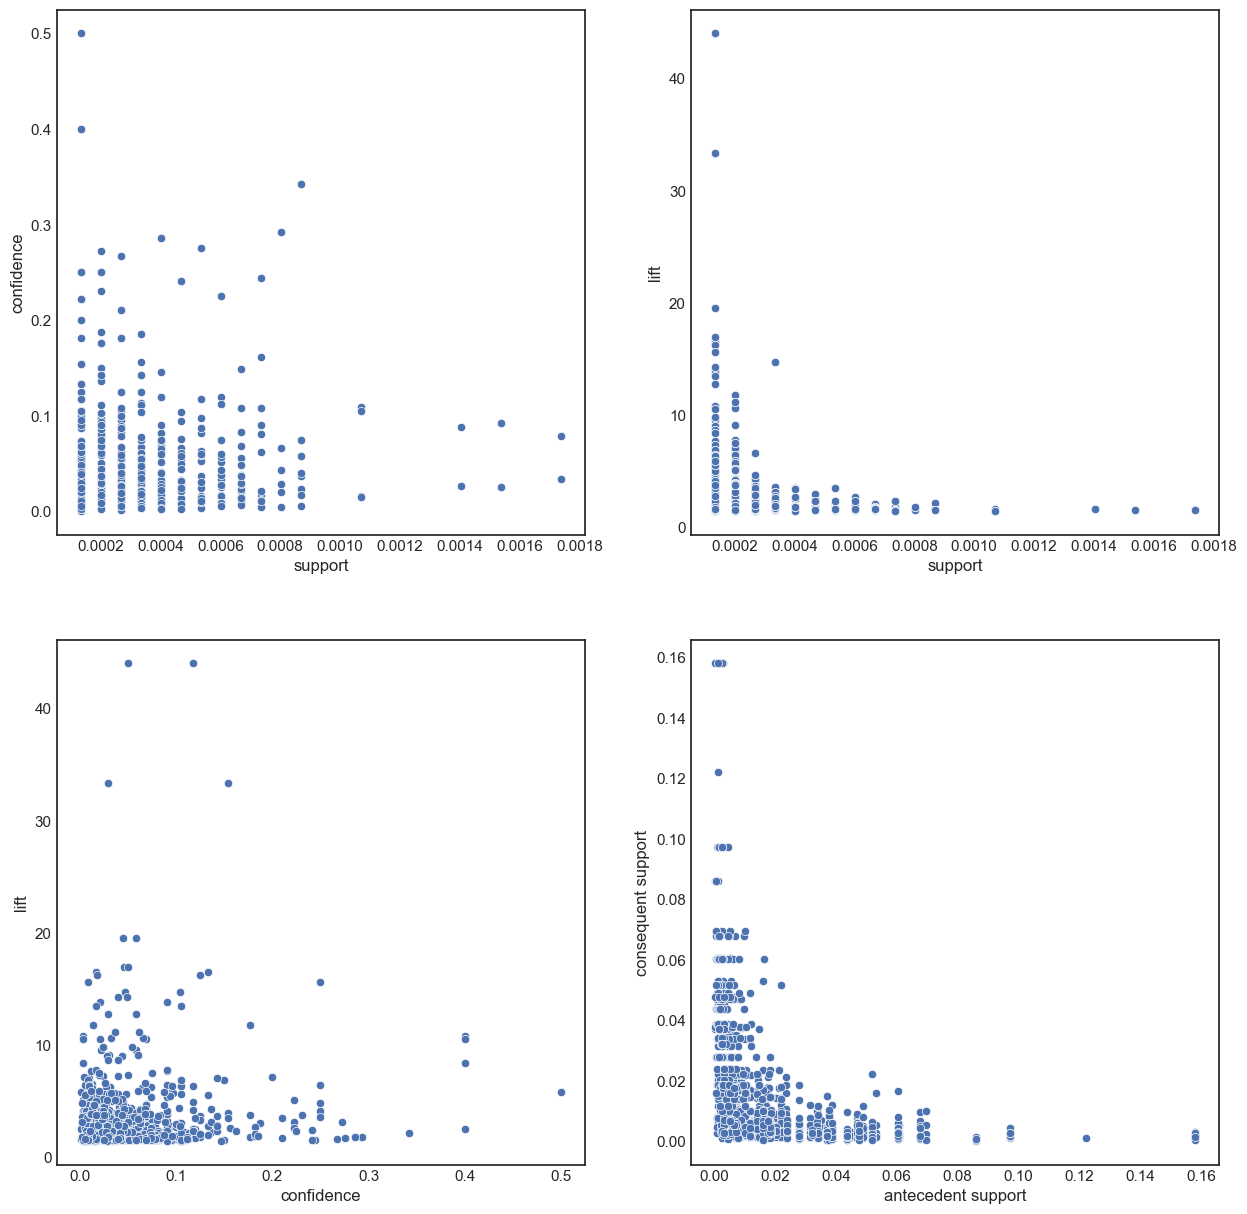

In [9]:
plt.figure(figsize = (15, 15))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=rules)
plt.subplot(222)
sns.scatterplot(x="support", y="lift",data=rules)
plt.subplot(223)
sns.scatterplot(x="confidence", y="lift",data=rules)
plt.subplot(224)
sns.scatterplot(x="antecedent support", y="consequent support",data=rules)